- General References:
    - https://www.kaggle.com/code/azminetoushikwasi/time-series-analysis-forecasting/notebook
    - https://www.kaggle.com/code/neomatrix369/everything-you-can-do-with-a-time-series-stocks/notebook
    - Practical Time Series Analysis by Aileen Nielsen, Chapter 8 

# Importing data

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import ta
from functools import reduce
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.volume import ChaikinMoneyFlowIndicator
import joblib
from sklearn.model_selection import RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression #ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')

In [2]:
CURR_DIR = os.getcwd()
DATA_DIR = os.path.join(CURR_DIR, 'Datasets')

In [3]:
btc = pd.read_csv(os.path.join(DATA_DIR,'btc.csv'),float_precision='high')
eth = pd.read_csv(os.path.join(DATA_DIR,'eth.csv'),float_precision='high')
ada = pd.read_csv(os.path.join(DATA_DIR,'ada.csv'),float_precision='high')
xrp = pd.read_csv(os.path.join(DATA_DIR,'xrp.csv'),float_precision='high')
bnb = pd.read_csv(os.path.join(DATA_DIR,'bnb.csv'),float_precision='high')

In [4]:
drop_features= ['textBlob_polarity','textBlob_subjectivity',
          'vader_compound','vader_negative_score','vader_positive_score','vader_neutral_score',
          'finbert_text_label','finbert_title_label','textBlob_label','vader_label','lm_label',
          'finBert_title_positive_score','finBert_title_negative_score','finBert_title_neutral_score']
btc.drop(drop_features,axis=1, inplace=True)
eth.drop(drop_features,axis=1, inplace=True)
ada.drop(drop_features,axis=1, inplace=True)
xrp.drop(drop_features,axis=1, inplace=True)
bnb.drop(drop_features,axis=1, inplace=True)

In [5]:
btc.date = pd.to_datetime(btc.date, infer_datetime_format=True)
eth.date = pd.to_datetime(eth.date, infer_datetime_format=True)
xrp.date = pd.to_datetime(xrp.date, infer_datetime_format=True)
ada.date = pd.to_datetime(ada.date, infer_datetime_format=True)
bnb.date = pd.to_datetime(bnb.date, infer_datetime_format=True)

In [6]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3533 entries, 0 to 3532
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         3533 non-null   datetime64[ns]
 1   open                         3533 non-null   float64       
 2   high                         3533 non-null   float64       
 3   low                          3533 non-null   float64       
 4   close                        3533 non-null   float64       
 5   volume                       3533 non-null   float64       
 6   market cap                   3533 non-null   float64       
 7   bchain/diff                  3533 non-null   float64       
 8   bchain/avbls                 3533 non-null   float64       
 9   bchain/hrate                 3533 non-null   float64       
 10  bchain/totbc                 3533 non-null   float64       
 11  finBert_text_positive_score  3533 non-null 

In [7]:
btc.describe().T

,count,mean,std,min,25%,50%,75%,max
open,3533.0,1.107262e+04,1.560894e+04,6.850500e+01,4.851290e+02,5.002578e+03,1.158548e+04,6.754974e+04
high,3533.0,1.135248e+04,1.600772e+04,7.456110e+01,4.993700e+02,5.184016e+03,1.189509e+04,6.878963e+04
low,3533.0,1.075931e+04,1.514843e+04,6.552600e+01,4.732340e+02,4.842910e+03,1.129079e+04,6.638206e+04
close,3533.0,1.107599e+04,1.560485e+04,6.843100e+01,4.857240e+02,5.014480e+03,1.159249e+04,6.756683e+04
volume,3533.0,1.399730e+10,1.935502e+10,0.000000e+00,4.396280e+07,4.267040e+09,2.487968e+10,3.509679e+11
market cap,3533.0,2.045734e+11,2.948641e+11,7.784112e+08,6.891791e+09,8.921273e+10,2.116434e+11,1.274831e+12
bchain/diff,3533.0,8.491444e+12,1.040457e+13,8.974296e+06,5.933535e+10,3.007384e+12,1.595865e+13,3.695049e+13
bchain/avbls,3533.0,8.374976e-01,3.870029e-01,7.209048e-02,5.321049e-01,9.343650e-01,1.151119e+00,1.571701e+00
bchain/hrate,3533.0,6.138634e+07,7.531224e+07,7.212891e+01,4.303698e+05,2.323673e+07,1.157306e+08,3.167823e+08
bchain/totbc,3533.0,1.636687e+07,2.314615e+06,1.108715e+07,1.466755e+07,1.689036e+07,1.844618e+07,1.924660e+07


# EDA

In [ ]:
btc.shape

In [ ]:
btc.info()

In [ ]:
btc.describe().T

In [ ]:
btc.isna().any()

In [ ]:
btc.isnull().sum()

In [ ]:
btc.duplicated().any()

In [ ]:
btc.set_index('date',inplace=True)
btc.sort_index(inplace=True)
eth.set_index('date',inplace=True)
eth.sort_index(inplace=True)
xrp.set_index('date',inplace=True)
xrp.sort_index(inplace=True)
ada.set_index('date',inplace=True)
ada.sort_index(inplace=True)
bnb.set_index('date',inplace=True)
bnb.sort_index(inplace=True)

In [ ]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(10, figsize=(14,25))
sns.lineplot(data=btc, x=btc.index ,y='open',ax = axes[0])
sns.lineplot(data=btc, x=btc.index ,y='high',ax = axes[1])
sns.lineplot(data=btc, x=btc.index ,y='low',ax = axes[2])
sns.lineplot(data=btc, x=btc.index ,y='close',ax = axes[3])
sns.lineplot(data=btc, x=btc.index ,y='volume',ax = axes[4])
sns.lineplot(data=btc, x=btc.index ,y='market cap',ax = axes[5])
sns.lineplot(data=btc, x=btc.index ,y='bchain/diff',ax = axes[6])
sns.lineplot(data=btc, x=btc.index ,y='bchain/avbls',ax = axes[7])
sns.lineplot(data=btc, x=btc.index ,y='bchain/hrate',ax = axes[8])
sns.lineplot(data=btc, x=btc.index ,y='bchain/totbc',ax = axes[9])
plt.suptitle(f"Bitcoin features over time")
plt.tight_layout()
plt.subplots_adjust(top=0.95)
sns.despine()
plt.show()

In [ ]:
sns.set_style('whitegrid')
open_prices = pd.DataFrame()
close_prices = pd.DataFrame()
high_prices = pd.DataFrame()
low_prices = pd.DataFrame()
volume = pd.DataFrame()
for year in ['2013', '2014', '2015', '2016', '2017', '2018','2019','2020', '2021']:
    open_price_per_year = btc.loc[year, ['open']].reset_index(drop=True)
    open_price_per_year.rename(columns={'open': year}, inplace=True)
    open_prices = pd.concat([open_prices, open_price_per_year], axis=1)
       
    high_price_per_year = btc.loc[year, ['high']].reset_index(drop=True)
    high_price_per_year.rename(columns={'high': year}, inplace=True)
    high_prices = pd.concat([high_prices, high_price_per_year], axis=1)
    
    close_price_per_year = btc.loc[year, ['close']].reset_index(drop=True)
    close_price_per_year.rename(columns={'close': year}, inplace=True)
    close_prices = pd.concat([close_prices, close_price_per_year], axis=1)
    
    low_price_per_year = btc.loc[year, ['low']].reset_index(drop=True)
    low_price_per_year.rename(columns={'low': year}, inplace=True)
    low_prices = pd.concat([low_prices, low_price_per_year], axis=1)
    
    volume_per_year = btc.loc[year, ['volume']].reset_index(drop=True)
    volume_per_year.rename(columns={'volume': year}, inplace=True)
    volume = pd.concat([volume, volume_per_year], axis=1)

fig, axes = plt.subplots(5,figsize=(14,25))
open_prices.plot(ax=axes[0])
axes[0].set_title('Comparing Open of Bitcoin of each year')
axes[0].set_xlabel('days')

close_prices.plot(ax=axes[1])
axes[1].set_title('Comparing Close of Bitcoin of each year')
axes[1].set_xlabel('days')

high_prices.plot(ax=axes[2])
axes[2].set_title('Comparing High of Bitcoin of each year')
axes[2].set_xlabel('days')

low_prices.plot(ax=axes[3])
axes[3].set_title('Comparing Low of Bitcoin of each year')
axes[3].set_xlabel('days')

volume.plot(ax=axes[4])
axes[4].set_title('Comparing Volume of Bitcoin of each year')
axes[4].set_xlabel('days')

plt.xlabel('days')
plt.tight_layout()
sns.despine()
plt.show()

In [ ]:
plt.fig, axes = plt.subplots(2,1,figsize=(14,10))
# Close comparison
btc.close.plot(ax=axes[0]), eth.close.plot(ax=axes[0]), xrp.close.plot(ax=axes[0]), bnb.close.plot(ax=axes[0])
ada.close.plot(ax=axes[0])
axes[0].set_title('Comparing Close of Bitcoin, Ethereum, Ripple, Binance Coin and Cardano over time')
axes[0].legend(['Bitcoin','Ethereum','Ripple','Binance Coin','Cardano'])

# Close normalized comparison
btc_norm = btc.close.div(btc.close.iloc[0]).mul(100)
eth_norm = eth.close.div(eth.close.iloc[0]).mul(100)
xrp_norm = xrp.close.div(xrp.close.iloc[0]).mul(100)
bnb_norm = bnb.close.div(bnb.close.iloc[0]).mul(100)
ada_norm = ada.close.div(ada.close.iloc[0]).mul(100)

btc_norm.plot(ax=axes[1]), eth_norm.plot(ax=axes[1]), xrp_norm.plot(ax=axes[1]), bnb_norm.plot(ax=axes[1])
ada_norm.plot(ax=axes[1])
axes[1].legend(['Bitcoin','Ethereum','Ripple','Binance Coin','Cardano'])
axes[1].set_title('Comparing of Close Bitcoin, Ethereum, Ripple, Binance Coin and Cardano Close over time (normalized)')

plt.tight_layout()
sns.despine()
plt.show()

In [ ]:
plt.fig, axes = plt.subplots(2,1,figsize=(14,10))
# volume comparison
btc.volume.plot(ax=axes[0]), eth.volume.plot(ax=axes[0]), xrp.volume.plot(ax=axes[0]), bnb.volume.plot(ax=axes[0])
ada.volume.plot(ax=axes[0])
axes[0].set_title('Comparing Volume of Bitcoin, Ethereum, Ripple, Binance Coin and Cardano over time')
axes[0].legend(['Bitcoin','Ethereum','Ripple','Binance Coin','Cardano'])

# volume normalized comparison
btc_norm = btc.volume.div(btc.volume.iloc[0]).mul(100)
eth_norm = eth.volume.div(eth.volume.iloc[0]).mul(100)
xrp_norm = xrp.volume.div(xrp.volume.iloc[0]).mul(100)
bnb_norm = bnb.volume.div(bnb.volume.iloc[0]).mul(100)
ada_norm = ada.volume.div(ada.volume.iloc[0]).mul(100)

btc_norm.plot(ax=axes[1]), eth_norm.plot(ax=axes[1]), xrp_norm.plot(ax=axes[1]), bnb_norm.plot(ax=axes[1])
ada_norm.plot(ax=axes[1])
axes[1].legend(['Bitcoin','Ethereum','Ripple','Binance Coin','Cardano'])
axes[1].set_title('Comparing Volume of Bitcoin, Ethereum, Ripple, Binance Coin and Cardano volume over time (normalized)')

sns.despine()
plt.show()

In [ ]:
fig, axes = plt.subplots(3, figsize=(14,12))
sns.set(rc={'figure.figsize':(24,8)})
sns.set_style('whitegrid')
sns.lineplot(data=btc, x=btc.index ,y=btc.close.pct_change(periods=1).mul(100),ax = axes[0])
axes[0].set_title("Bitcoin daily return")
sns.lineplot(data=btc, x=btc.index ,y=btc.close.pct_change(periods=30).mul(100),ax = axes[1])
axes[1].set_title("Bitcoin monthly return")                
sns.lineplot(data=btc, x=btc.index ,y=btc.close.pct_change(periods=365).mul(100),ax = axes[2])
axes[2].set_title("Bitcoin annual return")
                
plt.suptitle(f"Bitcoin return (Close) over time")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
sns.despine()
plt.show()

In [ ]:
# Statistics
fig, axes = plt.subplots(3, figsize=(14,12))

# Weekly
btc.close.plot(ax=axes[0])
btc.close.rolling(window=7).mean().plot(ax=axes[0])
btc.close.rolling(window=7).std().plot(ax=axes[0])
axes[0].legend(['Close','Mean','Standard Deviation'])
axes[0].set_title("Comparing Close with it's weekly rolling mean and std. dev")
# Monthly
btc.close.plot(ax=axes[1])
btc.close.rolling(window=30).mean().plot( ax=axes[1])
btc.close.rolling(window=30).std().plot( ax=axes[1])
axes[1].legend(['Close','Mean','Standard Deviation'])
axes[1].set_title("Comparing Close with it's monthly rolling mean and std. dev")
                  
# Yearly
btc.close.plot(ax=axes[2])
btc.close.rolling(window=365).mean().plot( ax=axes[2])
btc.close.rolling(window=365).std().plot( ax=axes[2])
plt.legend(['Original', 'Rolling mean', 'Rolling std'])
axes[2].legend(['Close','Mean','Standard Deviation'])
axes[2].set_title("Comparing Close with it's yearly rolling mean and std. dev")

plt.tight_layout()
sns.despine()
plt.show()

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(14, 10))
pd.plotting.lag_plot(btc.close, lag=1, ax=axes[0][0])
axes[0][0].set_title('Daily Lag')
pd.plotting.lag_plot(btc.close, lag=7, ax=axes[0][1])
axes[0][1].set_title('Weekly Lag')
pd.plotting.lag_plot(btc.close, lag=30, ax=axes[1][0])
axes[1][0].set_title('Monthly Lag')
pd.plotting.lag_plot(btc.close, lag=365, ax=axes[1][1])
axes[1][1].set_title('Yearly Lag')
plt.suptitle('Lag Plots (Close)')

plt.tight_layout()
sns.despine()
plt.show()

In [ ]:
#Autocorrelation: correlation between a time series and a delayed copy of itself
fig, axes = plt.subplots(2,1, figsize=(14, 7))
plot_acf(btc.close,lags=40,zero=False,title="Autocorrelation chart: Bitcoin (Close)", ax=axes[0])
axes[0].set_xlabel('Nr. of lags')

# Partial Autocorrelation: Extends idea by removing the effect of previous time points
# ex.: lag = 3 --> (t1-t4), (t2-t5), (t3-t3)
plot_pacf(btc.close,lags=40,zero=False, title="Partial autocorrelation chart: Bitcoin (Close)", ax=axes[1])
axes[1].set_xlabel('Nr. of lags')

plt.tight_layout()
sns.despine()
plt.show()

In [ ]:
decompose = seasonal_decompose(btc.close)
decompose_monthly =  seasonal_decompose(btc.close.resample('M').mean())
decompose.plot()
decompose_monthly.plot()
plt.show()

- We can observe an upward trend and a seasonal pattern -> ts is not stationary

In [ ]:
fig = go.Figure(data=go.Ohlc(x=btc.index,
                    open=btc.open,
                    high=btc.high,
                    low=btc.low,
                    close=btc.close))
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.update_layout(template='plotly_white', 
                  title="OHLC Closing price chart of Bitcoin")
fig.show()

In [ ]:
btc_art = btc.copy().reset_index()
btc_art['day_of_week']  = btc_art.date.dt.day_of_week
btc_art['month']  = btc_art.date.dt.month
btc_art['year']  = btc_art.date.dt.year

fig, axes = plt.subplots(3,1, figsize=(14,10))
s = sns.barplot(y=btc_art.groupby('year')['num_art'].sum(), x=btc_art.groupby('year')['num_art'].sum().index, ax=axes[0])
s = sns.barplot(y=btc_art.groupby('month')['num_art'].sum(), x=btc_art.groupby('month')['num_art'].sum().index, ax=axes[1])
s = sns.barplot(y=btc_art.groupby('day_of_week')['num_art'].sum(), x=btc_art.groupby('day_of_week')['num_art'].sum().index, ax=axes[2])
axes[2].legend(['Mon','Tues','Wed','Thur','Fri','Sat','Sun'])
plt.suptitle('Number of Article over time')
plt.tight_layout()
sns.despine()
plt.show()

In [ ]:
btc.head()

# Feature Engineering

In [8]:
# additional features - https://www.kaggle.com/code/cstein06/tutorial-to-the-g-research-crypto-competition#Preprocessing
def additional_features(df):
    df['upper_shadow'] = df.high - np.maximum(df.close, df.open)
    df['lower_shadow'] = df.low - np.minimum(df.close, df.open - df.low)
    df["close/open"] = df.close/ df.open
    df["close-open-volatility"] = df.close- df.open
    df["high/low"] = df.high / df.low
    df['high-low-volatility']= df.high - df.low

    # price change 
    df['return'] = df.close.diff()
    #df['log_return'] = np.log(df.close).diff()
    df.dropna(axis=0, inplace=True)
    
    return df

In [9]:
# lag featues
def lag_features(df, btc=True):
    if btc:
        features = ['open','high','low','close','volume','market cap','bchain/diff','bchain/avbls','bchain/hrate','bchain/totbc']
    else:
        features = ['open','high','low','close','volume','market cap']
    #features = df.select_dtypes([np.number]).columns
    #df_mean = df[features].shift().rolling(window=7).mean().aggregate([np.std, np.mean]))

    # mean for 7, and 30 day 
    df_mean_7 = df[features].rolling(window=7,min_periods=0).mean().shift()
    df_mean_7.columns = [f'{col}_mean_lag_7' for col in df_mean_7.columns]
    df_mean_30 = df[features].rolling(window=30,min_periods=0).mean().shift()
    df_mean_30.columns = [f'{col}_mean_lag_30' for col in df_mean_30.columns]

    # std for 7, and 30 days
    df_std_7 = df[features].rolling(window=7,min_periods=0).std().shift()
    df_std_7.columns = [f'{col}_std_lag_7' for col in df_std_7.columns]
    df_std_30 = df[features].rolling(window=30,min_periods=0).std().shift()
    df_std_30.columns = [f'{col}_std_lag_30' for col in df_std_30.columns]

    df= pd.concat([df, df_mean_7, df_std_7,df_mean_30, df_std_30], axis=1)
    df.fillna(df.mean(numeric_only=True),inplace=True)
    
    return df

In [10]:
# Technical stock market indicators
def tsi_features(df):
    # Bollinger Bands
    indicator_bb = BollingerBands(close=df.close, window=20, window_dev=2, fillna=True)
    df['average_band'] = indicator_bb.bollinger_mavg()
    df['upper_band'] = indicator_bb.bollinger_hband()
    df['lower_band'] = indicator_bb.bollinger_lband()

    # # Relative Strength Index - measures the speed and change of price movements
    df['rsi'] = ta.momentum.rsi(close=df.close, fillna=True)

    # Indicators
    # Moving Average Convergence Divergence - The value tells the relationship between two moving averages of a stock price
    indicator_macd= MACD(close=df.close, window_fast=12, window_slow=26, window_sign=9, fillna=True)
    df['macd'] = indicator_macd.macd()
    df['macd_diff'] = indicator_macd.macd_diff()
    df['macd_signal'] = indicator_macd.macd_signal()

    # Oscillator
    # Chaikin Money Flow (CMF) - measures the amount of Money Flow Volume over a specific period
    indicator_cmf = ChaikinMoneyFlowIndicator(high=df.high, low=df.low, close=df.close, volume=df.volume, window=20, fillna=True)
    df['cmf'] = indicator_cmf.chaikin_money_flow()
    
    return df

In [11]:
# # time
def time_features(df):
    df['day_of_week']  = df.date.dt.day_of_week
    df['month']  = df.date.dt.month
    df['year']  = df.date.dt.year
    df['weekend'] = df['weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['week'] = df.date.dt.isocalendar().week
    df['season'] = None
    df.loc[(df.month >= 3) & (df.month <= 5), 'season'] = '0'
    df.loc[(df.month >= 6) & (df.month <= 8), 'season'] = '1'
    df.loc[(df.month >= 9) & (df.month <= 11), 'season'] = '2'
    df.loc[(df.month == 12) | (df.month <= 2), 'season'] = '3'
    df.season = df.season.astype(int)
    
    return df

Tsfresh feature extracting

In [12]:
from tsfresh import extract_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_extraction.settings import from_columns
from tsfresh import select_features

# Calculated features were saved as csv file

# features = ['date','open','high','low','close','volume','market cap','bchain/diff','bchain/avbls','bchain/hrate','bchain/totbc']
# extracted_features = extract_features(df[features],column_id = "date",column_sort = "date")
# tsfreshBTC = extracted_features.copy()
# tsfreshBTC.to_csv('tsfreshBTC.csv',  header=True, index=False)

In [13]:
extracted_features = pd.read_csv(os.path.join(DATA_DIR, 'tsfreshBTC.csv'))
extracted_features = extracted_features.dropna(axis=1)
extracted_features['date'] = pd.to_datetime(extracted_features.date)
extracted_features.set_index('date', inplace=True)

In [14]:
y_frame = btc.set_index('date')
y = y_frame.close
y.sort_index(inplace=True)

In [15]:
relevance_table = calculate_relevance_table(extracted_features, y)
relevance_table = relevance_table[relevance_table.relevant]
relevance_table.sort_values("p_value", inplace=True)

In [16]:
top_50 = relevance_table.iloc[:50].index

In [17]:
X_tsfresh_filtered = select_features(extracted_features[top_50], y)
kind_to_fc_parameters = from_columns(X_tsfresh_filtered.columns.to_list())

In [18]:
X_tsfresh_filtered

,bchain/avbls__sum_values,"bchain/hrate__fft_coefficient__attr_""real""__coeff_0","high__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)",bchain/hrate__quantile__q_0.1,bchain/hrate__quantile__q_0.2,bchain/hrate__quantile__q_0.4,bchain/hrate__quantile__q_0.6,bchain/hrate__quantile__q_0.7,bchain/hrate__quantile__q_0.8,bchain/hrate__quantile__q_0.9,...,bchain/avbls__quantile__q_0.9,"bchain/avbls__cwt_coefficients__coeff_0__w_2__widths_(2, 5, 10, 20)","bchain/avbls__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","bchain/avbls__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)","bchain/avbls__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","bchain/avbls__fft_coefficient__attr_""real""__coeff_0","bchain/avbls__fft_coefficient__attr_""abs""__coeff_0",bchain/hrate__sum_values,bchain/avbls__quantile__q_0.6,"high__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)"
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,0.133635,8.074676e+01,37.295542,8.074676e+01,8.074676e+01,8.074676e+01,8.074676e+01,8.074676e+01,8.074676e+01,8.074676e+01,...,0.133635,0.081957,0.051834,0.036652,0.025917,0.133635,0.133635,8.074676e+01,0.133635,26.371931
2013-04-29,0.147566,7.463339e+01,40.451870,7.463339e+01,7.463339e+01,7.463339e+01,7.463339e+01,7.463339e+01,7.463339e+01,7.463339e+01,...,0.147566,0.090501,0.057238,0.040473,0.028619,0.147566,0.147566,7.463339e+01,0.147566,28.603792
2013-04-30,0.159960,7.463339e+01,40.298823,7.463339e+01,7.463339e+01,7.463339e+01,7.463339e+01,7.463339e+01,7.463339e+01,7.463339e+01,...,0.159960,0.098102,0.062045,0.043873,0.031023,0.159960,0.159960,7.463339e+01,0.159960,28.495571
2013-05-01,0.181150,7.212891e+01,38.367948,7.212891e+01,7.212891e+01,7.212891e+01,7.212891e+01,7.212891e+01,7.212891e+01,7.212891e+01,...,0.181150,0.111098,0.070264,0.049684,0.035132,0.181150,0.181150,7.212891e+01,0.181150,27.130236
2013-05-02,0.196927,7.363160e+01,34.448597,7.363160e+01,7.363160e+01,7.363160e+01,7.363160e+01,7.363160e+01,7.363160e+01,7.363160e+01,...,0.196927,0.120774,0.076384,0.054012,0.038192,0.196927,0.196927,7.363160e+01,0.196927,24.358836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-25,0.987937,2.478720e+08,4624.382402,2.478720e+08,2.478720e+08,2.478720e+08,2.478720e+08,2.478720e+08,2.478720e+08,2.478720e+08,...,0.987937,0.605893,0.383201,0.270964,0.191600,0.987937,0.987937,2.478720e+08,0.987937,3269.932156
2022-12-26,1.119264,2.267765e+08,4640.720711,2.267765e+08,2.267765e+08,2.267765e+08,2.267765e+08,2.267765e+08,2.267765e+08,2.267765e+08,...,1.119264,0.686435,0.434139,0.306983,0.217070,1.119264,1.119264,2.267765e+08,1.119264,3281.485084
2022-12-27,1.376405,2.021651e+08,4651.615583,2.021651e+08,2.021651e+08,2.021651e+08,2.021651e+08,2.021651e+08,2.021651e+08,2.021651e+08,...,1.376405,0.844137,0.533879,0.377510,0.266940,1.376405,1.376405,2.021651e+08,1.376405,3289.188922


# Model building

In [19]:
#https://stackoverflow.com/questions/65216794/importerror-when-importing-metric-from-sklearn# cant be imported
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.ones(len(y_true)), np.abs(y_true))))*100

In [20]:
def split_data(data):
    X = data.drop(['close'],axis=1)
    y = data.close.to_numpy().reshape(-1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=False, random_state=42)
    
    return X_train, X_test, y_train, y_test 

In [21]:
def train_models(X_train, y_train, pca=False, threshold=None):      
    if pca:
        pipelines = {
        'rf' : make_pipeline(StandardScaler(),PCA(n_components=threshold),RandomForestRegressor(random_state=42)),
        'gb':make_pipeline(StandardScaler(),PCA(n_components=threshold),GradientBoostingRegressor(random_state=42)),
        'lasso': make_pipeline(StandardScaler(),PCA(n_components=threshold), Lasso(random_state=42, max_iter=10000)),
         'ridge': make_pipeline(StandardScaler(),PCA(n_components=threshold), Ridge(random_state=42,))
        }
    else:
        pipelines = {
            'rf' : make_pipeline(RandomForestRegressor(random_state=42)),
            'gb':make_pipeline(GradientBoostingRegressor(random_state=42)),
            'lasso': make_pipeline(StandardScaler(), Lasso(random_state=42, max_iter=10000)),
            # Adds parameter (Lambda x (slope)2) and creates a small amount of bias
            # L2: Penalizes large positive or negative coefficients (steep slope)  
            # Features not shrunk to zero are selected by lasso

             'ridge': make_pipeline(StandardScaler(), Ridge(random_state=42,))
             # L1: Penalizes large positive or negative coefficients
        }

    params = {
        'rf':{
            'randomforestregressor__n_estimators': [100, 200, 300, 400, 500],
            'randomforestregressor__max_features': ['auto', 'sqrt', 'log2'],
            'randomforestregressor__min_samples_leaf': [1, 2, 5, 10],
            'randomforestregressor__max_depth': [10, 20, 30, 40, 50, None]
        },
        'gb':{
            'gradientboostingregressor__n_estimators': [100, 200, 300, 400, 500],
            'gradientboostingregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'gradientboostingregressor__max_depth': [1, 2, 3, 4, 5],
            'gradientboostingregressor__min_samples_leaf': [1, 2, 5, 10]

        },
        'lasso': {
            'lasso__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'lasso__max_iter': [10000, 15000, 20000]

        },
        'ridge':{
            'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
            'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']  
        }

    }
    
        
    models = {}
    tscv = TimeSeriesSplit(n_splits=5)
    
    for algo, pipeline in pipelines.items():
        print(f'Training the {algo} model')
        model = RandomizedSearchCV(pipeline, params[algo], n_jobs = -1, cv=tscv, return_train_score=True)
        model.fit(X_train, y_train)
        models[algo] = model
    
    return models

In [22]:
# Evaluate the performance on the model
def evalute_models(models, X_test, y_test):
    algo_name = []
    models_mse =[]
    models_rmse = []
    models_mae = []
    models_r2 = []
    model_evs = []
    models_mape = []
    
    for algo, model in models.items():
        y_pred = model.predict(X_test)
        algo_name.append(algo)
        mse = mean_squared_error(y_test, y_pred) #measure in target units  square(RMSE)
        models_mse.append(mse)
        rmse = np.sqrt(mse)
        models_rmse.append(rmse)
        mae = mean_absolute_error(y_test, y_pred)
        models_mae.append(mae)
        r2 = r2_score(y_test, y_pred)
        models_r2.append(r2)
        evs = explained_variance_score(y_test, y_pred)
        model_evs.append(evs)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        models_mape.append(mape)
        fig, ax = plt.subplots(figsize=(15, 5), sharex=True)
        ax.plot(X_test.index,y_test, color='k', lw=3)
        ax.plot(X_test.index,y_pred, color='r', lw=2)
        ax.set_title(f'Test set prediction for {algo} model')
        sns.despine() 
        plt.show()
        
        print(f' Metrics for {algo}: RMSE: {rmse:.2f}, MAE: {mae:.2f}, R^2: {r2:.2f}, EVS: {evs:.2f}, MAPE: {mape:.2f}')
    
    zipped = list(zip(algo_name, models_mse,models_rmse,models_mae,models_r2,models_mape))
    df_train_results = pd.DataFrame(zipped, columns=['algo','mse','rmse','mae','r2','mape'])
    return df_train_results

In [23]:
def save_trained_models(models, type):
    
    for algo, model in models.items():
        filename = algo + type + '.pkl'
        filepath = os.path.join(CURR_DIR, 'Models', filename)
        joblib.dump(model, filepath)

In [24]:
def feature_importance(trained_models,model, data):
    features = data.columns
    
    
    if model == 'lasso' or model == 'ridge':
        coef = trained_models[model].best_estimator_.named_steps[model].coef_
    elif model == 'rf':
        coef = trained_models['rf'].best_estimator_.named_steps['randomforestregressor'].feature_importances_
    elif model == 'gb':
        coef = trained_models['gb'].best_estimator_.named_steps['gradientboostingregressor'].feature_importances_
        
    plt.figure(figsize=(20,10))
    sns.barplot(y=features, x=coef).set_title(model, size=18)
    plt.show()

## Standard Features

In [25]:
df = btc.copy()
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [26]:
X_train, X_test, y_train, y_test = split_data(df)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(2826, 13) (707, 13) (2826,) (707,)


In [29]:
%%time
trained_models_sf = train_models(X_train, y_train)

Training the rf model


C:\Users\Daniel\.virtualenvs\Cryptocurrency_forecasting_using_sentiment-gfXO6wBw\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Training the gb model
Training the lasso model
Training the ridge model
CPU times: total: 18.8 s
Wall time: 2min 2s


In [ ]:
# cv_results = []
# for results in trained_models_sf:
#     #print(trained_models_sf[results].cv_results_)
#     cv_result = trained_models_sf[results].cv_results_
#     cv_results.append(cv_result)
# test = pd.DataFrame(cv_results)
# test.explode('mean_train_score','mean_train_score')

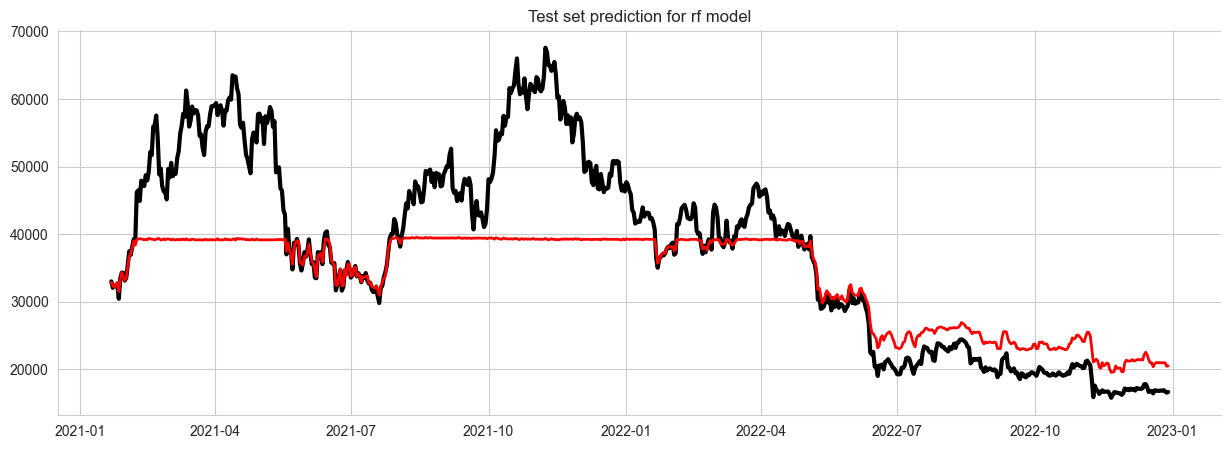

 Metrics for rf: RMSE: 9311.44, MAE: 6474.33, R^2: 0.56, EVS: 0.65, MAPE: 15.70


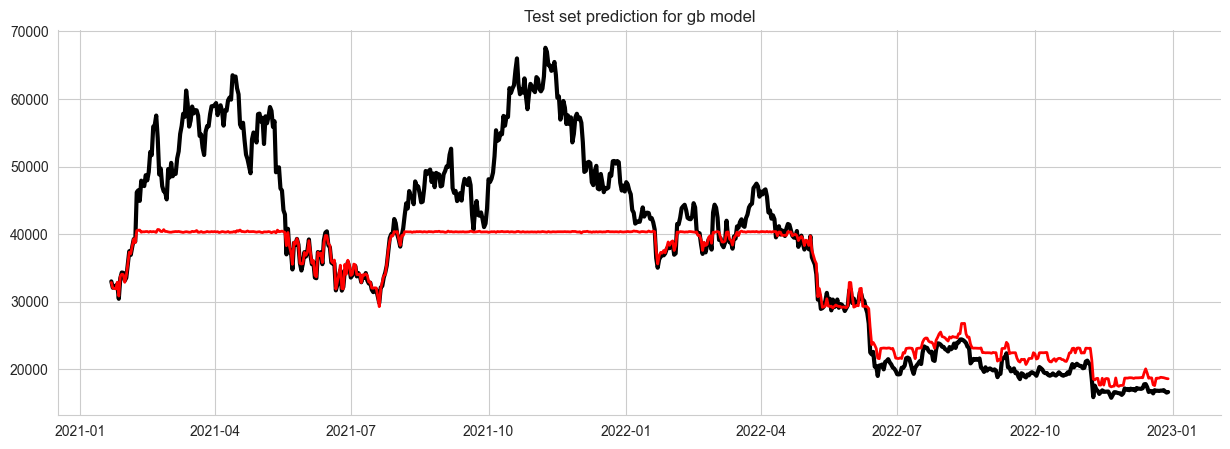

 Metrics for gb: RMSE: 8527.09, MAE: 5430.32, R^2: 0.63, EVS: 0.72, MAPE: 11.91


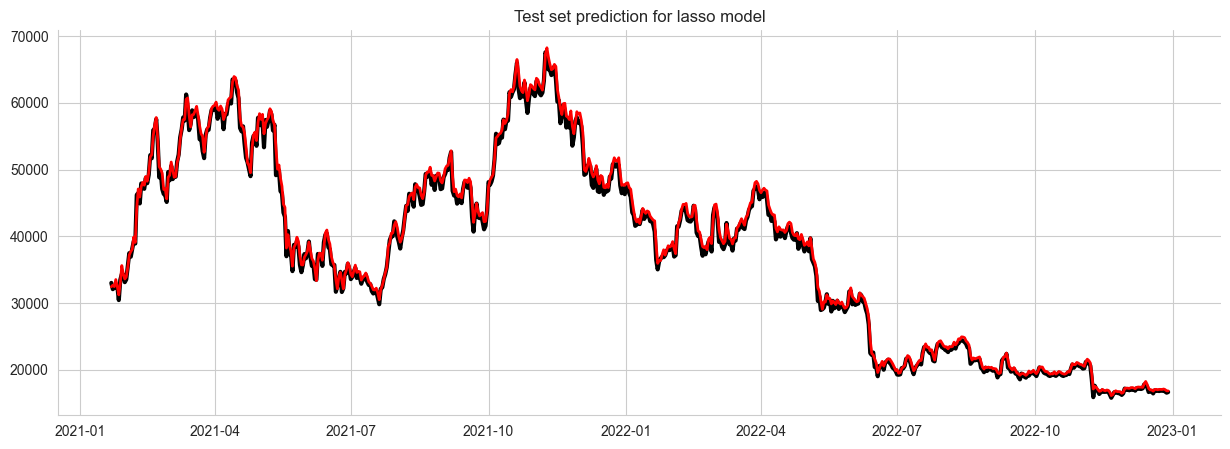

 Metrics for lasso: RMSE: 778.17, MAE: 596.96, R^2: 1.00, EVS: 1.00, MAPE: 1.61


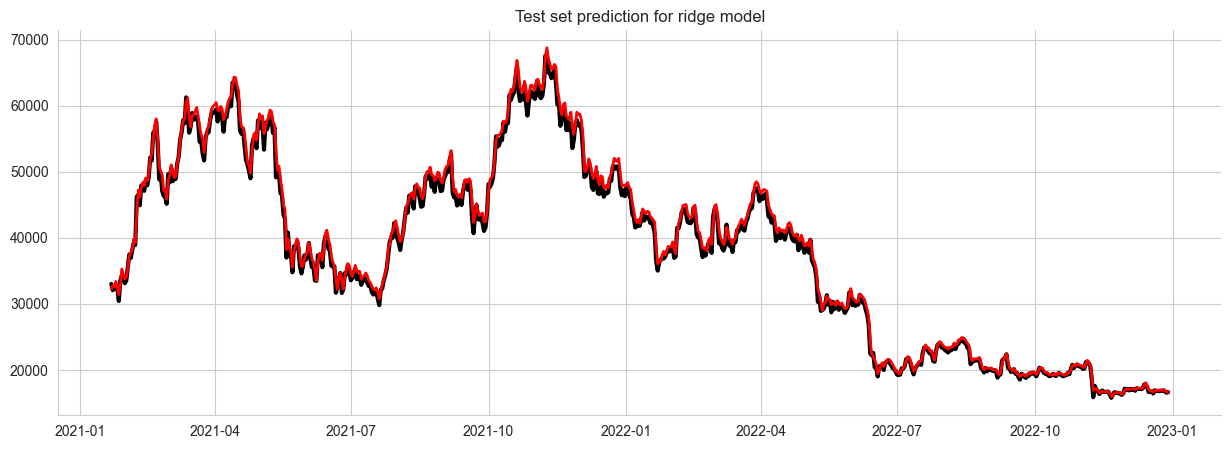

 Metrics for ridge: RMSE: 927.66, MAE: 714.52, R^2: 1.00, EVS: 1.00, MAPE: 1.80


In [30]:
evaluated_models = evalute_models(trained_models_sf, X_test,y_test)

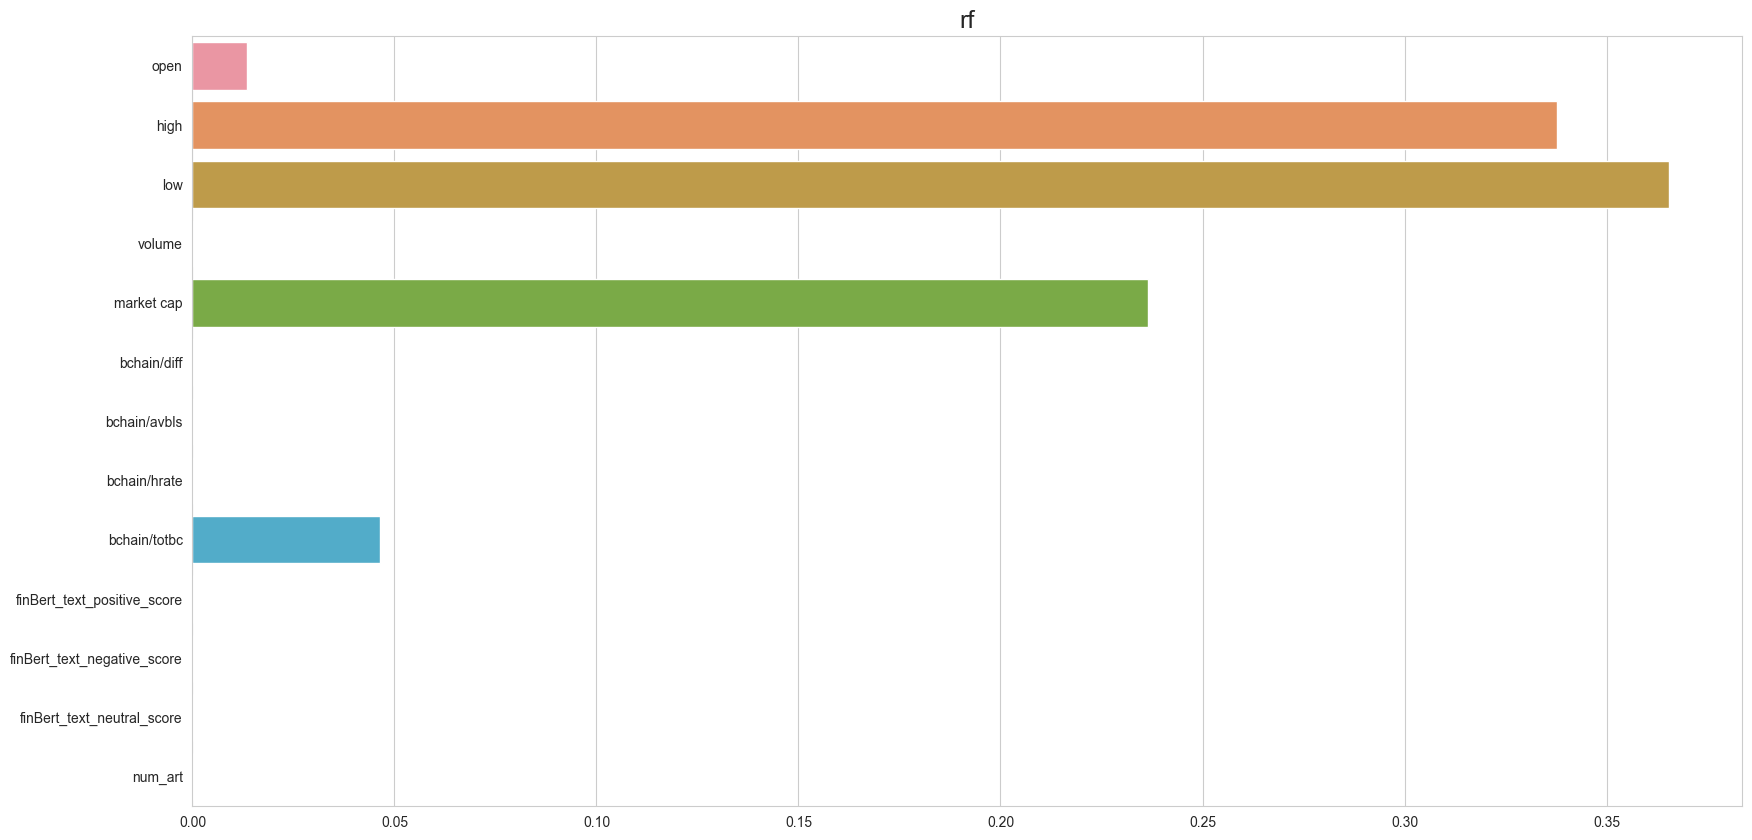

In [31]:
feature_importance(trained_models_sf, 'rf', X_test)

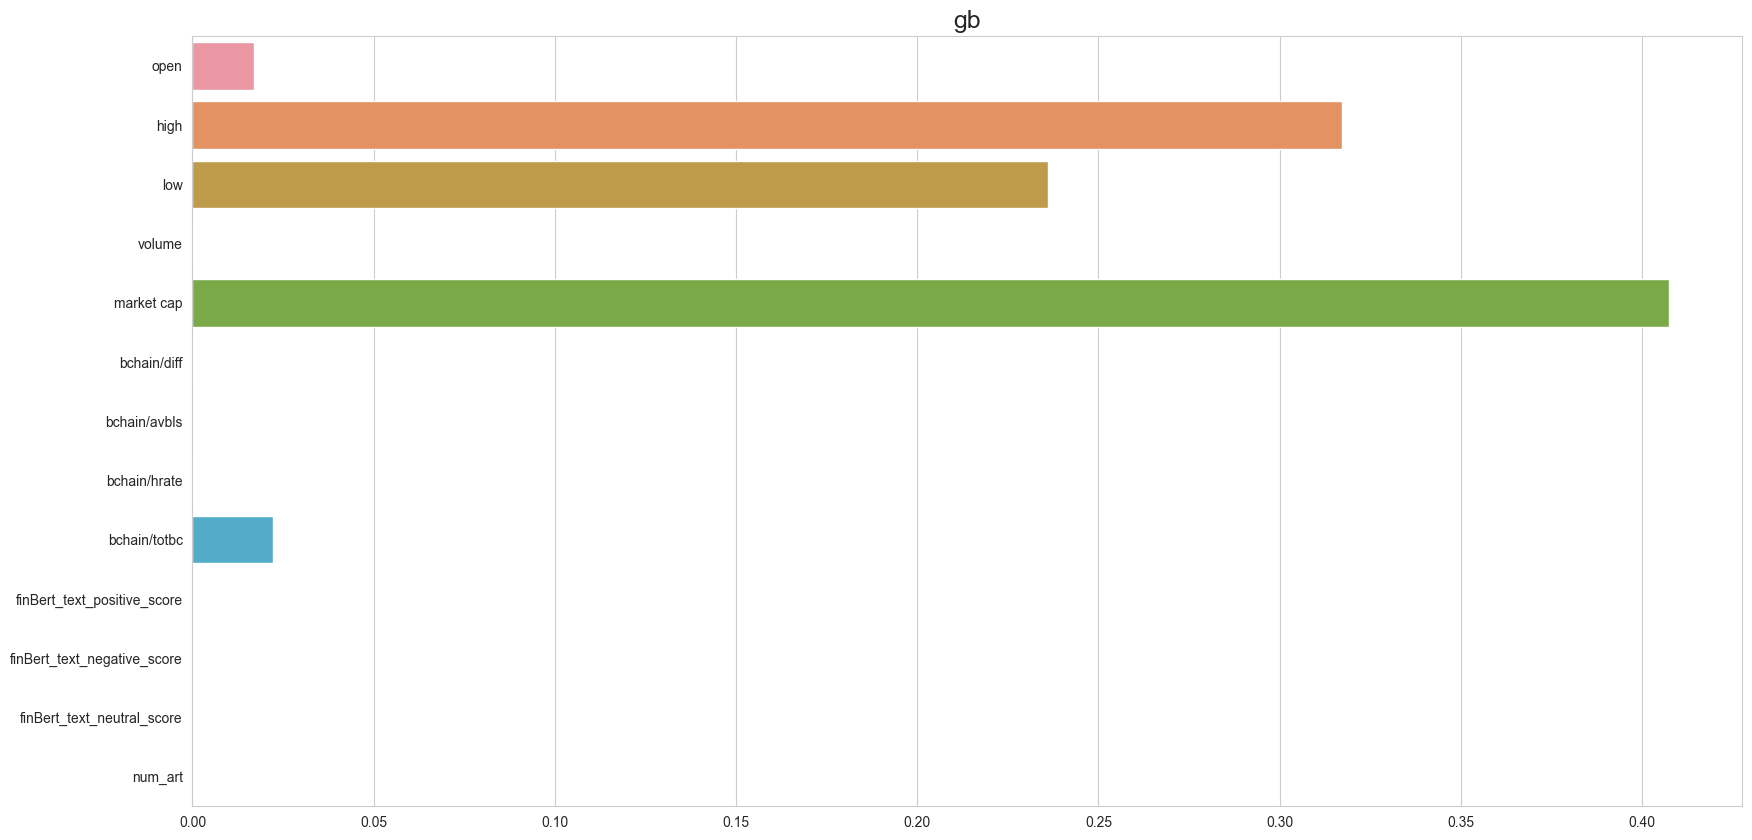

In [32]:
feature_importance(trained_models_sf, 'gb', X_test)

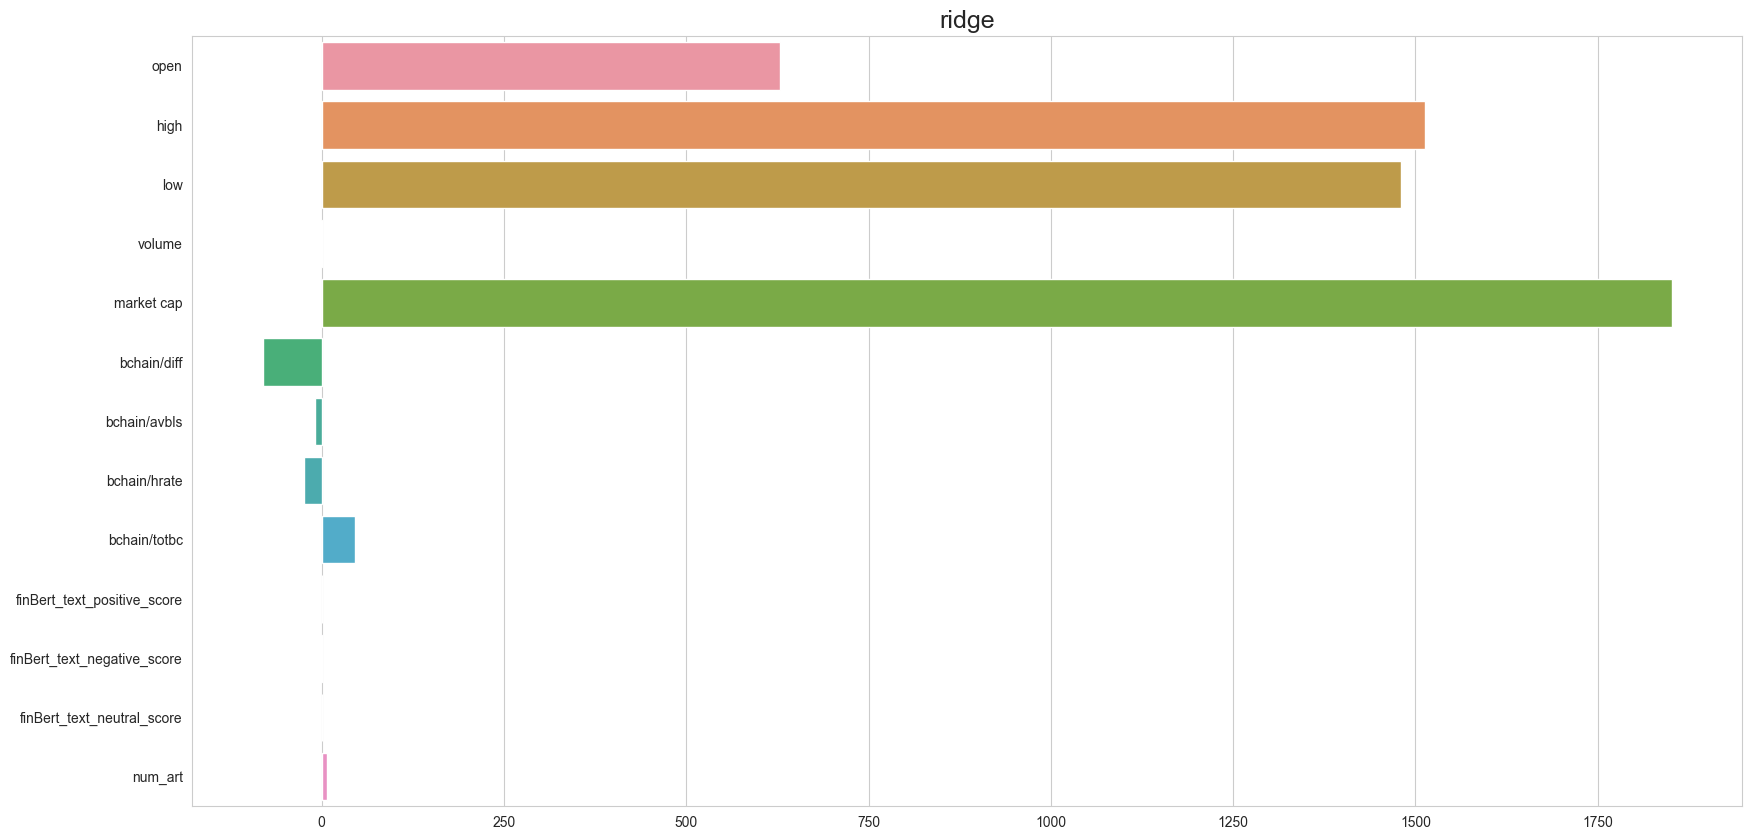

In [33]:
feature_importance(trained_models_sf, 'ridge', X_test)

In [ ]:
# Save models
save_trained_models(trained_models_sf, '_standard_features')

### Feature Extraction - Combining feature selectors (standard features)
 - Reference: DataCamp - Dimensionality Reduction in Python (Feature Selection II - Selecting for Model Accuracy)

In [35]:
X_train, X_test, y_train, y_test = split_data(df)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(2826, 13) (707, 13) (2826,) (707,)


In [36]:
tscv = TimeSeriesSplit(n_splits=5)

# LassoCV
lcv = LassoCV(cv=tscv,max_iter=10000, random_state=42).fit(X_train_scaled,y_train)
y_pred = lcv.predict(X_test_scaled)
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=True))
print('MAPE: ',mean_absolute_percentage_error(y_test,y_pred))
print('Optimal Alpha:', lcv.alpha_)
lcv_mask = lcv.coef_ !=0

RMSE:  767392.5460436103
MAPE:  1.7971661571507183
Optimal Alpha: 5.41887842096643


In [37]:
#Random Forest
rf_params = {'n_estimators': [100, 200, 300, 400, 500],
             'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_depth': [10, 20, 30, 40, 50, None]
            }
        
rf_reg_rfe = RFE(RandomForestRegressor(random_state=42), n_features_to_select=sum(lcv_mask), step=1).fit(X_train, y_train)
rf_reg_mask = rf_reg_rfe.support_

y_pred = rf_reg_rfe.predict(X_test)
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=True))
print('MAPE: ',mean_absolute_percentage_error(y_test,y_pred))

# rf_reg = RandomForestRegressor(random_state=42)
# rf_gd = RandomizedSearchCV(rf_reg, param_grid=rf_params, cv=tscv)
# rf_gd.fit(rf_reg_rfe.transform(X_train_scaled), y_train)
# y_pred = rf_gd.predict(X_test)
# print('MAPE: ',mean_absolute_percentage_error(y_test,y_pred ))
# rf_reg_mask = rf_reg.support_

RMSE:  79850989.37017095
MAPE:  14.103871519507111


In [38]:
gp_params = {'n_estimators': [100, 200, 300, 400, 500],
             'learning_rate': [0.01, 0.05, 0.1, 0.2],
             'max_depth': [1, 2, 3, 4, 5],
             'min_samples_leaf': [1, 2, 5, 10]
            }
                
gb_reg_rfe = RFE(GradientBoostingRegressor(random_state=42), n_features_to_select=sum(lcv_mask), step=1).fit(X_train, y_train)
gb_reg_mask = rf_reg_rfe.support_

y_pred = gb_reg_rfe.predict(X_test)
print('RMSE: ', mean_squared_error(y_test, y_pred, squared=True))
print('MAPE: ',mean_absolute_percentage_error(y_test,y_pred))

# gb_reg = GradientBoostingRegressor(random_state=42)
# gb_gd = RandomizedSearchCV(rf_reg, param_grid=rf_params, cv=tscv)
# gb_gd.fit(gb_reg_rfe.transform(X_train_scaled), y_train)

# y_pred = rf_gd.predict(X_test)
# print('MAPE: ',mean_absolute_percentage_error(y_test,y_pred ))
# gb_mask = rf_reg.support_

RMSE:  70587135.42707524
MAPE:  12.497408702851136


In [39]:
votes = np.sum([lcv_mask,rf_reg_mask,gb_reg_mask], axis=0)
mask = votes >=2
mask
# to do: test scores for new df with models
reduced_X = df.drop(['close'],axis=1).loc[:,mask]
reduced_X

,open,high,low,volume,market cap,bchain/totbc
date,,,,,,
2013-04-28,135.300003,135.979996,132.100006,0.000000e+00,1.488567e+09,11087150.00
2013-04-29,134.444000,147.488007,134.000000,0.000000e+00,1.603769e+09,11098475.00
2013-04-30,144.000000,146.929993,134.050003,0.000000e+00,1.542813e+09,11098275.00
2013-05-01,139.000000,139.889999,107.720001,0.000000e+00,1.298955e+09,11105600.00
2013-05-02,116.379997,125.599998,92.281898,0.000000e+00,1.168517e+09,11109275.00
...,...,...,...,...,...,...
2022-12-25,16847.505364,16860.553971,16755.253234,1.165638e+10,3.240932e+11,19243225.00
2022-12-26,16842.249311,16920.123640,16812.370076,1.188696e+10,3.256043e+11,19243975.00
2022-12-27,16919.291650,16959.846476,16642.073182,1.574858e+10,3.217172e+11,19244631.25


## Created features

In [51]:
df_cf = btc.copy()
df_cf = additional_features(df)
df_cf = lag_features(df_cf, btc=True)
df_cf = tsi_features(df_cf)

In [52]:
X_train, X_test, y_train, y_test = split_data(df_cf)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

(2824, 68) (707, 68) (2824,) (707,)


In [ ]:
%%time
trained_models_cf = train_models(X_train, y_train)

In [63]:
save_trained_models(trained_models_cf, '_created_features')

In [ ]:
evaluated_models = evalute_models(trained_models_cf, X_test,y_test)

- Result: The models seem to overfitting

### Feature Extraction - PCA (crafted features)

In [ ]:
%%time
trained_models_cf_pca = train_models(X_train, y_train, pca=True, threshold=0.9) #variance=0.9

In [66]:
save_trained_models(trained_models_cf_pca, '_created_features_pca')

In [ ]:
evaluated_models = evalute_models(trained_models_cf_pca, X_test,y_test)

In [ ]:
pca = trained_models_cf_pca['rf'].best_estimator_.named_steps['pca']
n_components = pca.components_
fig, ax = plt.subplots(1,2, figsize=(12,4))
explained_variance_ratio = pca.explained_variance_ratio_
sns.lineplot(explained_variance_ratio, ax =ax[0])
ax[0].set_xlabel('PCA index')
ax[0].set_ylabel('Explained variance ratio')

sns.lineplot(np.cumsum(pca.explained_variance_ratio_), ax=ax[1])
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Variance (%)')

sns.despine()
plt.show()

## TsFresh

In [ ]:
df_ts = btc.copy()
df_ts = additional_features(df_ts)
df_ts = lag_features(df_ts, btc=True)
df_ts = tsi_features(df_ts)
df_ts.set_index('date', inplace=True)
df_ts.sort_index(inplace=True)

In [ ]:
df_ts = df_ts.join(X_tsfresh_filtered)
df_ts

In [ ]:
X_train, X_test, y_train, y_test = split_data(df_ts)
print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)

In [ ]:
%%time
trained_models_ts = train_models(X_train, y_train, pca=True, threshold=20) # top20 components

In [151]:
save_trained_models(trained_models_ts, '_ts_features')

In [ ]:
evaluated_models = evalute_models(trained_models_ts, X_test,y_test)

In [ ]:
pca = trained_models_ts['rf'].best_estimator_.named_steps['pca']
n_components = pca.components_
fig, ax = plt.subplots(1,2, figsize=(12,4))
explained_variance_ratio = pca.explained_variance_ratio_
sns.lineplot(explained_variance_ratio, ax =ax[0])
ax[0].set_xlabel('PCA index')
ax[0].set_ylabel('Explained variance ratio')

sns.lineplot(np.cumsum(pca.explained_variance_ratio_), ax=ax[1])
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Variance (%)')

sns.despine()
plt.show()

## Forecasting (standard features)

In [10]:
CURR_DIR = os.getcwd()
DATA_DIR = os.path.join(CURR_DIR, 'Datasets')
BASE_DIR =os.path.dirname(os.path.dirname(os.getcwd()))
DATA_DIR_PRICE = os.path.join(BASE_DIR, r"Datasets\Price\Update")

In [11]:
btc = pd.read_csv(os.path.join(DATA_DIR,'btc.csv'),float_precision='high')
drop_features= ['textBlob_polarity','textBlob_subjectivity',
          'vader_compound','vader_negative_score','vader_positive_score','vader_neutral_score',
          'finbert_text_label','finbert_title_label','textBlob_label','vader_label','lm_label',
          'finBert_title_positive_score','finBert_title_negative_score','finBert_title_neutral_score']
btc.drop(drop_features,axis=1, inplace=True)
btc.date = pd.to_datetime(btc.date, infer_datetime_format=True)
price = pd.read_csv(os.path.join(DATA_DIR_PRICE,'bitcoin_price_data_all_time.csv'),float_precision='high')
ad_price = pd.read_csv(os.path.join(DATA_DIR_PRICE,'bitcoin_price_data_additional.csv'),float_precision='high')
latest_news = pd.read_csv(os.path.join(DATA_DIR,'latest_news.csv'),float_precision='high')

In [12]:
price.columns = price.columns.str.lower()
price.date = pd.to_datetime(price.date, infer_datetime_format=True)
price['date'] = price.date.dt.date

ad_price.columns = ad_price.columns.str.lower()
ad_price.date = pd.to_datetime(ad_price.date, infer_datetime_format=True)
ad_price['date'] = ad_price.date.dt.date

In [5]:
latest_news.date = pd.to_datetime(latest_news.date, infer_datetime_format=True)
latest_news['date'] = latest_news.date.dt.date
latest_news.drop(['coin', 'text','finBert_text'], axis=1, inplace=True)
latest_news['num_art'] = 1
latest_news = latest_news.groupby('date').agg({'finBert_text_positive_score':'mean',
                                 'finBert_text_negative_score':'mean',
                                 'finBert_text_neutral_score':'mean',
                                 'num_art':'count'})
latest_news.reset_index(inplace=True)

In [6]:
dfs = [latest_news, price[price.date.values==latest_news.date.values], ad_price[ad_price.date.values==latest_news.date.values]]

In [7]:
final_df = reduce(lambda  left,right: pd.merge(left,right,on=['date'],
                                            how='outer'), dfs)

In [8]:
future = pd.concat([btc, final_df])

In [9]:
future.date = pd.to_datetime(future.date, infer_datetime_format=True)

In [10]:
future.set_index('date', inplace=True)

In [11]:
future.sort_index(inplace=True)

In [12]:
index = pd.date_range(start='2013-04-28', end='2022-12-31', freq='D')
future = future.reindex(index)
future.interpolate(inplace=True)

In [13]:
close=future.close.values
dates = future.index

In [14]:
future.drop('close', inplace=True, axis=1)

In [13]:
filepath = os.path.join(CURR_DIR, 'Models')
rf_gridSearch_standard = joblib.load(os.path.join(filepath, 'rf_standard_features.pkl'))
#gb_gridSearch_standard  = joblib.load(os.path.join(filepath, 'gb_standard_features.pkl'))
lasso_gridSearch_standard  = joblib.load(os.path.join(filepath, 'lasso_standard_features.pkl'))
ridge_gridSearch_standard  = joblib.load(os.path.join(filepath,'ridge_standard_features.pkl'))

In [16]:
y_pred_rf = rf_gridSearch_standard.predict(future)
y_pred_lasso = lasso_gridSearch_standard.predict(future)
y_pred_ridge = ridge_gridSearch_standard.predict(future)

In [17]:
forecast = pd.DataFrame(y_pred_rf, columns=['forecast rf'])

In [18]:
forecast['forecast lasso'] = y_pred_lasso
forecast['forecast ridge'] = y_pred_ridge
forecast['actual close'] = close

In [19]:
forecast.set_index(index, inplace=True)

In [20]:
forecast.iloc[-1].to_frame().T

,forecast rf,forecast lasso,forecast ridge,actual close
2022-12-31,19540.125644,16779.366452,16620.592991,16547.495366


In [23]:
import plotly.express as px
fig = px.line(forecast)
fig.update_layout(template='plotly_white', 
                  title="Bitcoin Close Forecasting t+1")
fig.show()